# Importing Packages

In [1]:
"""
Importing (using/include) packages and files needed for the code to run

Note: that we import pyplot last to avoid a name conflict with grid
"""

using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using DataFrames
using PyCall
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [2]:
function initial_ice_depth(x::Float64)
    """
    Arguments:
    x::Float64 -- A horizontal value of float64

    Returns:
    The vertical value (depth) corresponding to the horizontal argument value

    Info:
    The initial topography setup follows the following.
    y = A*sin[k(x-b)]+c
    |A| is the amplitude
    k is the wave number (k=2π/wavelength)
    The period is 2π/k
    The horizontal shift is b
    The vertical shift is c
    """
    w = W
    A = 0.1*w
    k = (2*pi)/w
    b = 0.0
    c = 0.5*w
    return (A)*(sin(k*(x-b)))+(c)
end

function initial_surface_depth(x::Float64)
    """
    Arguments:
    x::Float64 -- A horizontal value of float64

    Returns:
    The vertical value (depth) corresponding to the horizontal argument value
    """
     return 1e4
end

function ice_viscosity(T::Float64)
    """
    Arguments:
    T::Float64 --- A temperature value in (Kelvin) of float64

    Returns:
    ice_vis -- The ice viscosity in (Pa*s) that is dependent on temperature argument value

    Info:
    The equation used is a Newtonian formulation for temperature-dependent ice viscosity from Nimmo(2004)
    """
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else
        ice_vis = ice_vis
    end
    return ice_vis
end

ice_viscosity (generic function with 1 method)

# Material Setup

In [3]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1e6],[0.5610,2.1,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1
            markers.scalars[T,i] = 273.0
        elseif mmat[i] == 3 
            markers.scalars[T,i] = 100.0
        end 
    end 
end 

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1] 
            markers.scalars[kThermal,i] = materials.kThermal[1]
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3]
            markers.scalars[kThermal,i] = materials.kThermal[3]
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end


function get_i_interface(grid::CartesianGrid,mat,contour_value)
    # Setting up inital model schematic
    i_interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if i_mat[i,j] == contour_value
                i_interface_position[j] = grid.yc[j]
                break
            elseif i_mat[i+1,j] < contour_value
                # interface is located within this cell.
                i_interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(i_mat[i+1,j]-i_mat[i,j])*(contour_value-i_mat[i,j])
                break
            end
            i = i+1
        end
    end
    return i_interface_position
end

function get_interface(grid::CartesianGrid,mat,contour_value)
    # Finding interfaces 
    interface_position = zeros(Float64,grid.nx+1);
        for j in 1:grid.nx+1
        i = 1
            while i <= grid.ny
                if mat[i,j] == contour_value
                    interface_position[j] = grid.yc[i]
                    break
                elseif mat[i+1,j] < contour_value
                    # interface is located within this cell.
                    interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                    break
                end
                i = i+1
            end
        end
    return interface_position
end

get_interface (generic function with 1 method)

# Model Setup

Creating Markers...
  0.044603 seconds (21 allocations: 74.159 MiB, 69.96% gc time)
Initial condition...
  0.463351 seconds (11.60 M allocations: 178.630 MiB, 8.40% gc time)
[1, -1, 1, 1][273.0, 0.0, 100.0, 273.0]
assigning left boundary temperature 273.0
Trying with timestep 0.1603113942795848 kyr
assigning left boundary temperature 273.0
dTmax=2.221029076253757 dt=0.1603113942795848 kyr
Writing visualization file = test/viz.0000.vtr
Writing visualization file = test/markers.0000.vtp
  0.005902 seconds (2 allocations: 10.986 MiB)
Finished Step 2 time=0.1603113942795848 kyr
assigning left boundary temperature 273.0
Trying with timestep 0.1624506964592161 kyr
assigning left boundary temperature 273.0
dTmax=1.66237359444969 dt=0.1624506964592161 kyr
Writing visualization file = test/viz.0001.vtr
Writing visualization file = test/markers.0001.vtp
  0.005984 seconds (2 allocations: 10.986 MiB)
Finished Step 3 time=0.3227620907388009 kyr
assigning left boundary temperature 273.0
Trying with

assigning left boundary temperature 273.0
dTmax=1.5501796143448132 dt=0.20263799671636065 kyr
Writing visualization file = test/viz.0021.vtr
Writing visualization file = test/markers.0021.vtp
  0.019283 seconds (6 allocations: 10.987 MiB, 31.11% gc time)
Finished Step 23 time=3.8738383497970243 kyr
assigning left boundary temperature 273.0
Trying with timestep 0.20784077681465715 kyr
assigning left boundary temperature 273.0
dTmax=1.56323019495116 dt=0.20784077681465715 kyr
Writing visualization file = test/viz.0022.vtr
Writing visualization file = test/markers.0022.vtp
  0.019996 seconds (6 allocations: 10.987 MiB, 31.32% gc time)
Finished Step 24 time=4.081679126611681 kyr
assigning left boundary temperature 273.0
Trying with timestep 0.2130562000771965 kyr
assigning left boundary temperature 273.0
dTmax=1.5748842211820602 dt=0.2130562000771965 kyr
Writing visualization file = test/viz.0023.vtr
Writing visualization file = test/markers.0023.vtp
  0.022283 seconds (6 allocations: 10.9

Trying with timestep 0.37460847100095573 kyr
assigning left boundary temperature 273.0
dTmax=1.7551460980150466 dt=0.37460847100095573 kyr
Writing visualization file = test/viz.0043.vtr
Writing visualization file = test/markers.0043.vtp
  0.019410 seconds (6 allocations: 10.987 MiB, 22.64% gc time)
Finished Step 45 time=10.449369695956152 kyr
assigning left boundary temperature 273.0
Trying with timestep 0.3772620245610123 kyr
assigning left boundary temperature 273.0
dTmax=1.7242019226487741 dt=0.3772620245610123 kyr
Writing visualization file = test/viz.0044.vtr
Writing visualization file = test/markers.0044.vtp
  0.019676 seconds (6 allocations: 10.987 MiB, 22.30% gc time)
Finished Step 46 time=10.826631720517165 kyr
assigning left boundary temperature 273.0
Trying with timestep 0.3791993480739834 kyr
assigning left boundary temperature 273.0
dTmax=1.6902988399797607 dt=0.3791993480739834 kyr
Writing visualization file = test/viz.0045.vtr
Writing visualization file = test/markers.00

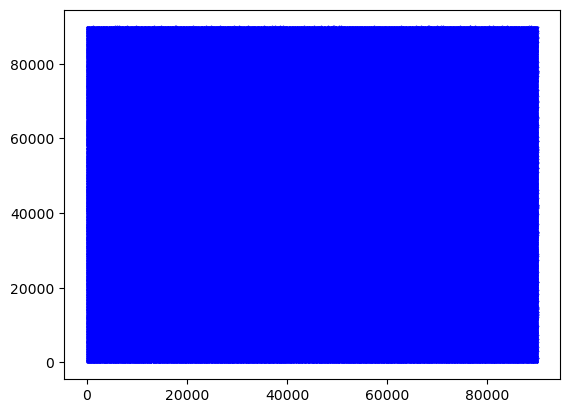

In [10]:
nx = 101
ny = 201
W = 90000.0
H = 90000.0
gx = 0.0
gy = 0.113


# Tbctype = [-1,-1,1,1] #left, right, top, bottom
Tbctype = [1,-1,1,1]
# Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
Tbcval = [273.0,0.0,100.0,273.0]
bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
materials = Materials()

markx = 6
marky = 6
seconds_in_year = 3.15e7
"""
time/seconds_in_year/1e6 is Millions of Years
time/seconds_in_year/1e3 is Thousands of Years
time/seconds_in_year is Years
time is Seconds
"""
plot_interval = 1e6*seconds_in_year # plot interval in seconds
end_time = 3e7*seconds_in_year
dtmax = plot_interval
grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr","kThermal"],["material"] ; nmx=markx,nmy=marky,random=true)
println("Initial condition...")
@time initial_conditions!(markers,materials)

time_plot = []
max_topo = []
### Setting up agruments for interface function ###
# initial 
i_air_ice_interface = zeros(Float64,grid.nx+1)
i_ocean_ice_interface = zeros(Float64,grid.nx+1)
i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
i_air_ice_interface = get_i_interface(grid,i_mat,2.5)
i_ocean_ice_interface = get_i_interface(grid,i_mat,1.5)

# after 
air_ice_interface = zeros(Float64,grid.nx+1)
ocean_ice_interface = zeros(Float64,grid.nx+1)
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")


### Setting up agruments for termination criteria ###
max_step::Int64=50
max_time::Float64=-1.0
max_time::Float64 = max_time == -1.0 ? typemax(Float64) : max_time
max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step

# kThermal = 3.0 .* ones(grid.ny+1,grid.nx+1);

time = 0.0
iout= 0
last_plot = 0.0
dt = 1e10

rho_c = nothing
rho_vx = nothing 
rho_vy = nothing 
alpha = nothing 
Hr = nothing 
Cp_c = nothing 
eta_s = nothing 
eta_n = nothing 
vxc = nothing 
vyc = nothing 
T = nothing 
dTmax = nothing 
dTemp = nothing 
Tnew = nothing 
Tlast = nothing 
x_time = nothing
kThermal = nothing

itime = 1
output_dir = "test"

terminate = false
while !terminate
    # 0. update the markers properties  
    update_marker_prop!(markers,materials)
    update_marker_temp!(markers,materials)
    # 1. Transfer properties markers -> nodes
    # 1a. Basic Nodes
    eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic")
    # 1b. Cell Centers
    rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new,kThermal_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr","kThermal"],"center")
    # 1c. Vx and Vy nodes:
    rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
    rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 

    # deal with any NaN values from interpolation:
    if itime > 1
        if any(isnan.(eta_s_new))
            println("found nan values")
        end
        replace_nan!(eta_s,eta_s_new)
        replace_nan!(rho_c,rho_c_new)
        replace_nan!(Hr,Hr_new)
        replace_nan!(Cp_c,Cp_c_new)
        replace_nan!(alpha,alpha_new)
        replace_nan!(eta_n,eta_n_new)
        replace_nan!(Tlast,Tlast_new)
        replace_nan!(rho_vx,rho_vx_new)
        replace_nan!(rho_vy,rho_vy_new)
        replace_nan!(kThermal,kThermal_new)
    end
    # Copy field data 
    kThermal = copy(kThermal_new)
    rho_vx = copy(rho_vx_new)
    rho_vy = copy(rho_vy_new)
    rho_c = copy(rho_c_new)
    Hr = copy(Hr_new)
    Cp_c = copy(Cp_c_new)
    alpha = copy(alpha_new)
    eta_s = copy(eta_s_new)
    eta_n = copy(eta_n_new)
    Tlast = copy(Tlast_new)
    
    if itime == 1 
        println(Tbctype,Tbcval)
        Tlast = ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        cell_center_to_markers!(markers,grid,Tlast,"T")
    else
        Tlast = ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
    end
    
    # 2. Assemble and solve the stokes equations
    L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
    stokes_solution = L\R
    vx,vy,P = unpack(stokes_solution,grid;ghost=true)

    # Get the velocity at the cell centers:
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)*0.0
    shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)*0.0
    H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0
    
    # 3. Compute the advection timestep
    if itime > 1
        this_dtmax = min(1.2*dt,dtmax)
    else
        this_dtmax = dtmax
    end
    dt = compute_timestep(grid,vxc,vyc;dtmax=this_dtmax,cfl=0.25)
    diffusion_timestep = (grid.x[2]-grid.x[1])^2 / 1e-6
    if dt > diffusion_timestep
        println("using diffusion timestep ",dt/3.15e7," yr")
        dt = diffusion_timestep
    end

    dTmax = Inf
    dTemp = nothing
    Tnew = nothing
    titer = 1
    for titer=1:2
        # assemble and solve the energy equation
        println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
        L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval)
        Tnew = L\R;
        Tnew = reshape(Tnew,grid.ny,grid.nx);
        Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval)
        T = copy(Tnew)
        
        dTemp = Tnew-Tlast
        # compute the maximum temperature change
        dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
        println("dTmax=",dTmax," dt=",dt/seconds_in_year/1e3," kyr")
        dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
        if dTmax < 10.0
            break
        end
    end

    dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
    dT_remaining = dTemp - dT_subgrid_node

    cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
    
    # Checking Termination Criteria, time is in Myr
    if time >= max_time || itime >= max_step
        terminate = true
    end    
    
    if time == 0.0 || mod(itime,100) == 0 || true
        last_plot = time 
        # Gird output
        name1 = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
        println("Writing visualization file = ",name1)
        vn = velocity_to_basic_nodes(grid,vxc,vyc)
        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name1)
        # Markers output
        name2 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
        println("Writing visualization file = ",name2)
        visualization(markers,time/seconds_in_year;filename=name2)
        iout += 1
    end

    # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))            
    # Moving the markers and advancing to the next timestep
    move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
    time += dt
    itime += 1
    println("Finished Step ",itime," time=",time/seconds_in_year/1e3," kyr")
    x_time = @sprintf("%.3g",time/3.15e7/1e6);
    mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    ocean_ice_interface = get_interface(grid,mat,1.5)
    air_ice_interface = get_interface(grid,mat,2.5)
    append!(time_plot,time)
    append!(max_topo,maximum(ocean_ice_interface.-(0.5*90000.0)))
end

figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

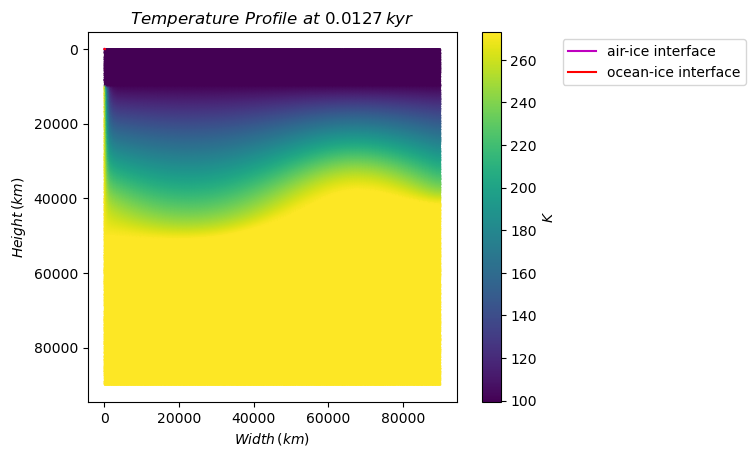

In [12]:
figure()
scatter(markers.x[1,1:markers.nmark],markers.x[2,1:markers.nmark],c=markers.scalars[[markers.scalarFields["T"]],1:markers.nmark],s=0.1)
plot(grid.xc/1000,air_ice_interface/1000,"m",label="air-ice interface")
plot(grid.xc/1000,ocean_ice_interface/1000,"r",label="ocean-ice interface")
title(L"Temperature\,\,Profile\,\,at\,\,%$x_time\,kyr")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

In [13]:
println("Maximum temperature in T: ",maximum(markers.scalars[markers.scalarFields["T"],:]))
println("Minimum temperature in T: ",minimum(markers.scalars[markers.scalarFields["T"],:]))
println("Maximum temperature in T matrix: ",maximum(T))
println("Minimum temperature in T matrix: ",minimum(T))
println("Maximum temperature in Tnew matrix: ",maximum(Tnew))
println("Minimum temperature in Tnew matrix: ",minimum(Tnew))
println("Maximum temperature in Tlast matrix: ",maximum(Tlast))
println("Minimum temperature in Tlast matrix: ",minimum(Tlast))

Maximum temperature in T: 273.005417103682
Minimum temperature in T: 0.0
Maximum temperature in T matrix: 446.1250544156213
Minimum temperature in T matrix: 99.87494558437871
Maximum temperature in Tnew matrix: 446.1250544156213
Minimum temperature in Tnew matrix: 99.87494558437871
Maximum temperature in Tlast matrix: 446.00000000000006
Minimum temperature in Tlast matrix: 99.99999999999984


In [14]:
DataFrame(dTemp,:auto)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.125054,-0.125054,-4.52148e-5,-1.6348e-8,-5.94014e-12,-1.42109e-14,-2.84217e-14,-1.42109e-14,0.0,-1.42109e-14,-1.42109e-14,-1.42109e-14,0.0,-2.84217e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-2.84217e-14,-1.42109e-14,0.0,-2.84217e-14,-2.84217e-14,-1.42109e-14,-1.42109e-14,-1.42109e-14,-1.42109e-14,-1.42109e-14,-2.84217e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-1.42109e-14,-1.42109e-14,-2.84217e-14,-1.42109e-14,-1.42109e-14,-2.84217e-14,-2.84217e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-1.42109e-14,-1.42109e-14,-1.42109e-14,0.0,0.0,-1.42109e-14,-4.26326e-14,0.0,-2.84217e-14,-1.42109e-14,-1.42109e-14,-1.42109e-14,-2.84217e-14,-1.42109e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-2.84217e-14,-1.42109e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-1.42109e-14,0.0,-2.84217e-14,-2.84217e-14,0.0,-1.42109e-14,-1.42109e-14,-1.42109e-14,-2.84217e-14,-1.42109e-14,0.0,0.0,-1.42109e-14,-2.84217e-14,-1.42109e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-2.84217e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-1.42109e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-1.42109e-14,-2.84217e-14,-2.84217e-14,-1.42109e-14,-1.42109e-14,-2.84217e-14,-1.42109e-14,-1.42109e-14,⋯
2,-0.125054,0.125054,4.52148e-5,1.6348e-8,5.94014e-12,1.42109e-14,2.84217e-14,1.42109e-14,0.0,1.42109e-14,1.42109e-14,1.42109e-14,0.0,2.84217e-14,2.84217e-14,2.84217e-14,1.42109e-14,2.84217e-14,1.42109e-14,0.0,2.84217e-14,2.84217e-14,1.42109e-14,1.42109e-14,1.42109e-14,1.42109e-14,1.42109e-14,2.84217e-14,2.84217e-14,2.84217e-14,1.42109e-14,2.84217e-14,2.84217e-14,1.42109e-14,1.42109e-14,1.42109e-14,2.84217e-14,1.42109e-14,1.42109e-14,2.84217e-14,2.84217e-14,2.84217e-14,2.84217e-14,1.42109e-14,1.42109e-14,1.42109e-14,1.42109e-14,0.0,0.0,1.42109e-14,4.26326e-14,0.0,2.84217e-14,1.42109e-14,1.42109e-14,1.42109e-14,2.84217e-14,1.42109e-14,2.84217e-14,2.84217e-14,1.42109e-14,2.84217e-14,1.42109e-14,2.84217e-14,2.84217e-14,1.42109e-14,1.42109e-14,0.0,2.84217e-14,2.84217e-14,0.0,1.42109e-14,1.42109e-14,1.42109e-14,2.84217e-14,1.42109e-14,0.0,0.0,1.42109e-14,2.84217e-14,1.42109e-14,2.84217e-14,2.84217e-14,1.42109e-14,2.84217e-14,2.84217e-14,2.84217e-14,1.42109e-14,1.42109e-14,2.84217e-14,2.84217e-14,1.42109e-14,1.42109e-14,2.84217e-14,2.84217e-14,1.42109e-14,1.42109e-14,2.84217e-14,1.42109e-14,1.42109e-14,⋯
3,-0.125416,0.125416,4.54763e-5,1.64898e-8,6.01119e-12,1.42109e-14,1.42109e-14,1.42109e-14,1.42109e-14,0.0,0.0,0.0,2.84217e-14,1.42109e-14,1.42109e-14,0.0,2.84217e-14,2.84217e-14,1.42109e-14,2.84217e-14,2.84217e-14,2.84217e-14,0.0,2.84217e-14,1.42109e-14,1.42109e-14,1.42109e-14,2.84217e-14,1.42109e-14,0.0,2.84217e-14,2.84217e-14,2.84217e-14,1.42109e-14,1.42109e-14,2.84217e-14,0.0,1.42109e-14,2.84217e-14,4.26326e-14,1.42109e-14,2.84217e-14,1.42109e-14,4.26326e-14,2.84217e-14,

In [15]:
DataFrame(Tnew,:auto)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,446.125,99.8749,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,⋯
2,445.875,100.125,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,⋯
3,445.875,100.125,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,⋯
4,445.875,100.125,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,⋯
5,445.875,100.125,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1